<a href="https://colab.research.google.com/github/castrokelly/eEDB-001-2023-4/blob/main/Cidades_Submersas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Cidades Submersas

Os dados estão disponibilizados na plataforma Kaggle: https://www.kaggle.com/datasets/kkhandekar/global-sea-level-1993-2021

#Aprendizado de Máquina Supervisionado: Regressão

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

#Bibliotecas


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install --upgrade scikit-learn
!pip install --upgrade imbalanced-learn


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gc

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import TruncatedSVD, PCA

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score

from sklearn.metrics import (accuracy_score,
                             classification_report,
                             confusion_matrix,
                             roc_curve,
                             roc_auc_score)
from imblearn.over_sampling import SMOTE
from tabulate import tabulate
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')


#Carregamento dos dados

In [5]:
df = pd.read_csv('/content/sealevel.csv', encoding='utf-8', sep=',')

#Detalhes do Dataframe

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048 entries, 0 to 1047
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Year                         1048 non-null   int64  
 1   TotalWeightedObservations    1048 non-null   float64
 2   GMSL_noGIA                   1048 non-null   float64
 3   StdDevGMSL_noGIA             1048 non-null   float64
 4   SmoothedGSML_noGIA           1048 non-null   float64
 5   GMSL_GIA                     1048 non-null   float64
 6   StdDevGMSL_GIA               1048 non-null   float64
 7   SmoothedGSML_GIA             1048 non-null   float64
 8   SmoothedGSML_GIA_sigremoved  1048 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 73.8 KB


In [7]:
df.describe()

,Year,TotalWeightedObservations,GMSL_noGIA,StdDevGMSL_noGIA,SmoothedGSML_noGIA,GMSL_GIA,StdDevGMSL_GIA,SmoothedGSML_GIA,SmoothedGSML_GIA_sigremoved
count,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000
mean,2006.742366,326568.269981,4.645515,87.007700,4.702004,8.112557,87.062805,8.168273,8.213044
std,8.231978,28044.226934,26.351001,5.525201,26.171990,28.310139,5.557840,28.138879,27.976127
min,1993.000000,906.100000,-44.390000,77.410000,-39.780000,-43.140000,77.420000,-39.770000,-39.110000
25%,2000.000000,327418.897500,-18.250000,83.510000,-17.882500,-16.615000,83.617500,-16.087500,-17.440000
50%,2007.000000,331979.205000,1.930000,85.925000,1.505000,5.465000,85.935000,5.065000,5.170000
75%,2014.000000,335243.865000,25.857500,88.602500,26.115000,30.942500,88.732500,31.095000,29.697500
max,2021.000000,341335.090000,57.920000,118.720000,56.310000,64.390000,118.760000,63.070000,60.560000


In [8]:
df.sample(10)

,Year,TotalWeightedObservations,GMSL_noGIA,StdDevGMSL_noGIA,SmoothedGSML_noGIA,GMSL_GIA,StdDevGMSL_GIA,SmoothedGSML_GIA,SmoothedGSML_GIA_sigremoved
887,2017,334209.91,32.62,83.64,33.99,38.46,83.64,39.84,41.34
103,1995,336421.59,-30.34,90.47,-23.70,-29.65,90.51,-23.02,-27.98
321,2001,319445.81,-4.13,83.97,-5.97,-2.02,84.15,-3.84,-8.83
986,2019,330003.41,53.68,92.21,54.91,60.20,92.95,61.43,56.45
632,2010,334193.09,6.70,86.79,9.33,10.87,86.55,13.51,15.55
577,2008,330326.50,7.27,87.58,8.31,11.09,87.86,12.14,7.58
83,1995,327903.50,-31.35,87.19,-30.00,-30.80,87.17,-29.44,-26.68
187,1998,324843.81,-22.19,108.25,-22.55,-20.96,108.24,-21.32,-20.05
631,2010,335135.19,14.73,88.76,9.97,18.90,88.67,14.14,15.98
428,2004,333818.59,-0.29,86.37,-1.81,2.53,86.52,1.03,-1.22


In [9]:
df.columns

Index(['Year', 'TotalWeightedObservations', 'GMSL_noGIA', 'StdDevGMSL_noGIA',
       'SmoothedGSML_noGIA', 'GMSL_GIA', 'StdDevGMSL_GIA', 'SmoothedGSML_GIA',
       'SmoothedGSML_GIA_sigremoved'],
      dtype='object')

In [10]:
df.isna().sum()

Year                           0
TotalWeightedObservations      0
GMSL_noGIA                     0
StdDevGMSL_noGIA               0
SmoothedGSML_noGIA             0
GMSL_GIA                       0
StdDevGMSL_GIA                 0
SmoothedGSML_GIA               0
SmoothedGSML_GIA_sigremoved    0
dtype: int64

In [11]:
df.shape

(1048, 9)

In [12]:
print("tamanho:",df.size)

tamanho: 9432


## 2. Correlação entre Atributos Preditivos Numéricos


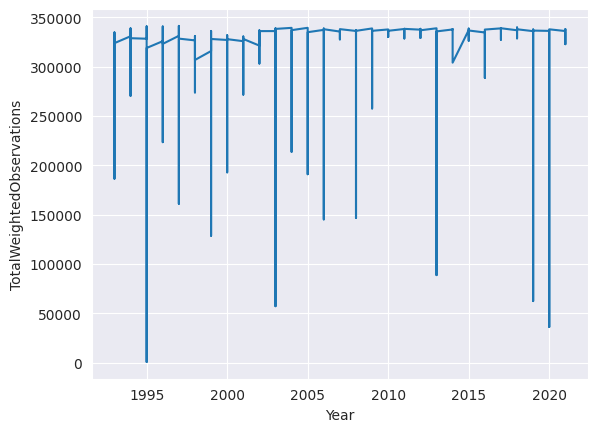

In [13]:
year = df['Year']
two = df['TotalWeightedObservations']
plt.plot(year,two)
plt.xlabel('Year')
plt.ylabel('TotalWeightedObservations')

plt.show()

## Pipelines de Pre-processamento
